# Transcription Factor Project - Analysis
**Robin Anwyl, UCSD Subramaniam Lab**

**Goal:** Analyze the hiPSC Perturb-seq dataset from the Mali lab (Nourreddine et al preprint) to investigate the effects of transcription factor knockouts (TF KOs)

**Guiding Questions:**
*  What TF KOs are present in the dataset? 
*  When performing clustering with the dataset - can we associate a unique set of TFs with a cluster? Is there any functional significance to these clusters?
*  What gene targets are associated with these TFs?
*  Which TFs are involved in co-regulation, and which genes are co-regulated? Which TFs are regulated by other TFs?
*  How do TFs influence chromatin remodeling? Which sets of writers and erasers are regulated by these TFs?

***

# Import statements

In [1]:
import muon as mu
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
#import re
#import requests
import gc
#from plotnine import ggplot, aes, geom_bar, ggtitle, xlab, ylab, scale_fill_manual, geom_histogram, labs, theme, element_text, scale_y_continuous
#from sklearn.ensemble import IsolationForest
#from sklearn.svm import OneClassSVM
from tqdm.auto import tqdm
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
from scipy.stats import ks_2samp
from scipy.stats import gamma
from scipy.stats import spearmanr
import seaborn as sns
#import dcor
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
import networkx as nx
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
#import openpyxl
from IPython.display import display  #type: ignore
from scipy.spatial.distance import pdist, squareform #type: ignore
import plotly.express as px #type: ignore
import plotly.graph_objects as go #type: ignore
import pymde #type: ignore
import plotly.io as pio #type: ignore
from sklearn.preprocessing import StandardScaler #type: ignore
from sklearn.neighbors import kneighbors_graph #type: ignore
from sklearn.manifold import SpectralEmbedding
import igraph as ig #type: ignore
import leidenalg #type: ignore
import sys
import os
sys.path.insert(0, "/home/ranwyl/data_tf_project/")
import perturb_seq_heuristic_pipeline as qc
import pan_genome_analysis_functions as qc2

Note: use terminal command " watch -n 0.1 free -h " to watch how much memory is being used

# Downstream Analysis (TF KO and NTC dataset)

Read in set of TFs

In [2]:
# List of 1639 TFs from Lambert et al (2018)
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
tfs = set(tfs)

Read in differential expression analysis results from TF KO and NTC dataset

In [ ]:
deg_df = pd.read_excel("/home/ranwyl/results_tf_project/TF_KO_NTC_Aggregate_DEGs.xlsx", index_col=0)

## Use DEA results to determine which TF KOs are strong perturbations (>= 10 DEGs)

Write function to determine which perturbations are TF KOs with >= 10 DEGs

In [ ]:
def determine_strong_perturbation_tf_kos(combined_degs, tf_set, deg_cutoff=10):
    # Identify the _DEGs columns
    deg_columns = [col for col in combined_degs.columns if '_DEGs' in col]

    # Filter perturbations that are TF KOs
    deg_columns = [col for col in deg_columns if col.split("_")[0] in tf_set]
    
    # Count the non-NaN values in each _DEGs column
    non_nan_counts = combined_degs[deg_columns].notna().sum()

    # Filter out column trios with fewer than 10 DEGs
    valid_deg_columns = non_nan_counts[non_nan_counts >= deg_cutoff].index.tolist()

    # Sort the remaining _DEGs columns based on the count
    sorted_deg_columns = non_nan_counts.loc[valid_deg_columns].sort_values(ascending=False).index.tolist()

    # Rearrange the DataFrame keeping the valid three adjacent columns together
    sorted_columns = []
    for deg_col in sorted_deg_columns:
        # Identify the corresponding L2FC and Adj_P columns
        base_name = deg_col.replace('_DEGs', '')
        l2fc_col = f'{base_name}_L2FC'
        adj_p_col = f'{base_name}_Adj_P'
        
        # Add these columns to the sorted list
        sorted_columns.extend([deg_col, l2fc_col, adj_p_col])

    # Rearrange the DataFrame with only the valid columns
    filtered_combined_degs = combined_degs[sorted_columns]
    return filtered_combined_degs

In [ ]:
strong_pert_deg_df = determine_strong_perturbation_tf_kos(deg_df, tfs)
strong_pert_deg_df

,POU5F1_DEGs,POU5F1_L2FC,POU5F1_Adj_P,PHF20_DEGs,PHF20_L2FC,PHF20_Adj_P,POU3F2_DEGs,POU3F2_L2FC,POU3F2_Adj_P,POU5F1B_DEGs,...,VDR_Adj_P,GRHL2_DEGs,GRHL2_L2FC,GRHL2_Adj_P,ETS1_DEGs,ETS1_L2FC,ETS1_Adj_P,AKAP8L_DEGs,AKAP8L_L2FC,AKAP8L_Adj_P
0,DGKB,-6.076206,0.020763,SLC22A23,-4.365596,0.002348,MYC,-3.849306,0.004563,ENSG00000289399,...,0.006946,ENSG00000197462,-1.372026,0.026750,TMSB10,-0.455466,0.048759,MT-ND5,-0.744941,0.046801
1,AP3B2,-5.457997,0.046913,ATG101,-4.360231,0.044251,OCLN,-3.215691,0.026427,ZNF134,...,0.006946,LINC02335,-1.320307,0.002374,ROBO2,-0.430676,0.048759,MT-CYB,-0.561085,0.004071
2,TRNP1,-5.160944,0.004823,ORAI1,-4.315618,0.048677,DBNDD2,-3.139128,0.006128,STC2,...,0.006946,MT-CYB,-0.566358,0.000007,RPS13,-0.315417,0.048759,MT-ATP6,-0.460241,0.000713
3,ENSG00000259048,-5.015852,0.000079,SUCLG1,-3.572351,0.003897,ENSG00000289399,-3.050469,0.002413,LIN7A,...,0.046353,MT-ATP6,-0.314984,0.002192,PTMA,-0.204787,0.048759,MT-ND4,-0.457726,0.005517
4,SYNPO2,-4.207629,0.040667,ZNF581,-3.460301,0.037650,PEX7,-2.853733,0.021551,DISC1,...,0.039598,MT-CO2,-0.287463,0.004888,LARGE1,0.445472,0.048759,MT-CO2,-0.454638,0.000122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1833,ENSG00000254202,8.638068,0.000195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1834,DLX5,8.798191,0.000137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1835,MEIS2,9.215727,0.000053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1836,DLK1,9.618622,0.000020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
687 // 3

229

Based on DEA results for the TF KO and NTC cell dataset, there are still only 229 TF KOs that are considered strong perturbations.

## Filter TF KO cells

Read in batch-corrected TF KO and NTC dataset

In [ ]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_TF_KO_NTC_Batch_Normalized.h5ad")

Filter TF KO cells

In [ ]:
print(f"number of cells before filtering: {adata.obs.shape[0]}")
adata_tfs = adata[adata.obs["gene_target"].isin(tfs)].copy()
print(f"number of cells after filtering: {adata_tfs.obs.shape[0]}")

number of cells before filtering: 69241


number of cells after filtering: 31808


### Display TF KO info and plot histogram

Number of unique TF KOs

In [ ]:
unique_tfs = adata_tfs.obs["gene_target"].unique().tolist()
print(len(unique_tfs))

652


Number of cells per TF KO

In [ ]:
cells_per_tf_ko = adata_tfs.obs['gene_target'].value_counts()

In [ ]:
print(cells_per_tf_ko[:5])

gene_target
ZFP41       209
ARHGAP35    186
DNMT1       150
ZNF354A     139
BHLHE40     139
Name: count, dtype: int64


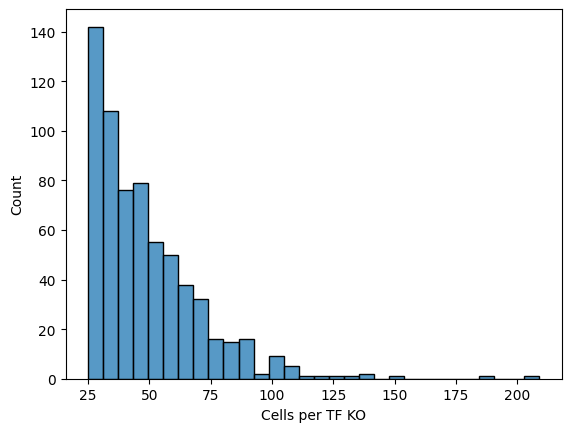

In [ ]:
ax = sns.histplot(cells_per_tf_ko.values, bins=30)
p = plt.xlabel("Cells per TF KO")

## Display cells per batch in a dataset

In [ ]:
def cells_per_batch(adata, dataset_name):
    for run in "ALPHA", "BETA", "GAMMA":
        print(f"In {dataset_name}, run {run} has {adata[adata.obs['run'] == run].shape[0]} cells")

## Filter genes

Write function to get set of DEGs that pass LFC threshold based on differential gene expression data

In [ ]:
def filter_degs_lfc(deg_df, lfc_threshold=0.25):
    # Get list of perturbations from column labels
    perts = {col.split("_")[0] for col in deg_df.columns}
    # Get genes where |L2FC| > threshold
    lfc_degs = set()
    for pert in perts:
        deg_col = f"{pert}_DEGs"
        l2fc_col = f"{pert}_L2FC"
        if deg_col in deg_df.columns and l2fc_col in deg_df.columns:
            lfc_degs.update(deg_df.loc[deg_df[l2fc_col].abs() > lfc_threshold, deg_col])
    return lfc_degs

Generate set of DEGs with |LFC| > 0.25

In [ ]:
degs_filt = filter_degs_lfc(deg_df)
# Print results
degs_filt_list = list(degs_filt)
print(degs_filt_list[:10])
print(len(degs_filt))

['THEM4', 'PFKFB3', 'TMEM35B', 'FOCAD', 'FAT1', 'MAP2K4', 'ZNF398', 'ENSG00000226824', 'PARP8', 'RRAS2']
5820


Filter out genes that are present in fewer than 25 cells, based on study pipeline

In [ ]:
sc.pp.filter_genes(adata_tfs, min_cells=25) # Filter for genes that are present in at least 25 cells
adata_tfs

filtered out 13046 genes that are detected in less than 25 cells


AnnData object with n_obs × n_vars = 31808 × 24521
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

### Test different gene filtering approaches with LFC threshold of 0.25

Generate set of 2000 HVGs

In [ ]:
adata_tfs_2000_hvg = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_tfs_2000_hvg, n_top_genes=2000, subset=False, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)
unique_hvg_2000 = set(adata_tfs_2000_hvg[:, adata_tfs_2000_hvg.var['highly_variable']].var.index)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


Generate set of 3000 HVGs

In [ ]:
adata_tfs_3000_hvg = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_tfs_3000_hvg, n_top_genes=3000, subset=False, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)
unique_hvg_3000 = set(adata_tfs_3000_hvg[:, adata_tfs_3000_hvg.var['highly_variable']].var.index)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


Generate set of 4000 HVGs

In [ ]:
adata_tfs_4000_hvg = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_tfs_4000_hvg, n_top_genes=4000, subset=False, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)
unique_hvg_4000 = set(adata_tfs_4000_hvg[:, adata_tfs_4000_hvg.var['highly_variable']].var.index)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


Generate set of 5000 HVGs

In [ ]:
adata_tfs_5000_hvg = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_tfs_5000_hvg, n_top_genes=5000, subset=False, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)
unique_hvg_5000 = set(adata_tfs_5000_hvg[:, adata_tfs_5000_hvg.var['highly_variable']].var.index)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


Take union of set of DEGs that pass LFC threshold and set of HVGs

In [ ]:
genes_union_2000 = list(degs_filt.union(unique_hvg_2000))
print(f"Number of genes in union of 5800 DEGs and 2000 HVGs: {len(genes_union_2000)}")
genes_union_3000 = list(degs_filt.union(unique_hvg_3000))
print(f"Number of genes in union of 5800 DEGs and 3000 HVGs: {len(genes_union_3000)}")
genes_union_4000 = list(degs_filt.union(unique_hvg_4000))
print(f"Number of genes in union of 5800 DEGs and 4000 HVGs: {len(genes_union_4000)}")
genes_union_5000 = list(degs_filt.union(unique_hvg_5000))
print(f"Number of genes in union of 5800 DEGs and 5000 HVGs: {len(genes_union_5000)}")

Number of genes in union of 5800 DEGs and 2000 HVGs: 7019
Number of genes in union of 5800 DEGs and 3000 HVGs: 7628
Number of genes in union of 5800 DEGs and 4000 HVGs: 8264
Number of genes in union of 5800 DEGs and 5000 HVGs: 8803


Take intersection of set of DEGs that pass LFC threshold and set of HVGs

In [ ]:
genes_intersec_2000 = list(degs_filt.intersection(unique_hvg_2000))
print(f"Number of genes in intersection of 5800 DEGs and 2000 HVGs: {len(genes_intersec_2000)}")
genes_intersec_3000 = list(degs_filt.intersection(unique_hvg_3000))
print(f"Number of genes in intersection of 5800 DEGs and 3000 HVGs: {len(genes_intersec_3000)}")
genes_intersec_4000 = list(degs_filt.intersection(unique_hvg_4000))
print(f"Number of genes in intersection of 5800 DEGs and 4000 HVGs: {len(genes_intersec_4000)}")
genes_intersec_5000 = list(degs_filt.intersection(unique_hvg_5000))
print(f"Number of genes in intersection of 5800 DEGs and 5000 HVGs: {len(genes_intersec_5000)}")

Number of genes in intersection of 5800 DEGs and 2000 HVGs: 801
Number of genes in intersection of 5800 DEGs and 3000 HVGs: 1192
Number of genes in intersection of 5800 DEGs and 4000 HVGs: 1556
Number of genes in intersection of 5800 DEGs and 5000 HVGs: 2017


### Test different LFC thresholds

LFC threshold 0.5

In [ ]:
degs_filt_05 = filter_degs_lfc(deg_df, lfc_threshold=0.5)
# Print results
degs_filt_list = list(degs_filt_05)
print(degs_filt_list[:10])
print(len(degs_filt_05))

['PSMD2', 'EIF1AX', 'ENSG00000288749', 'PCM1', 'ENSG00000291234', 'GLMN', 'SF3B3', 'POU5F1', 'KHDC4', 'RPS19BP1']
5818


LFC threshold 0.585

In [ ]:
degs_filt_0585 = filter_degs_lfc(deg_df, lfc_threshold=0.585)
# Print results
degs_filt_list = list(degs_filt_0585)
print(degs_filt_list[:10])
print(len(degs_filt_0585))

['THEM4', 'PFKFB3', 'TMEM35B', 'FOCAD', 'FAT1', 'MAP2K4', 'ZNF398', 'ENSG00000226824', 'PARP8', 'RRAS2']
5814


LFC threshold 0.75

In [ ]:
degs_filt_075 = filter_degs_lfc(deg_df, lfc_threshold=0.75)
# Print results
degs_filt_list = list(degs_filt_075)
print(degs_filt_list[:10])
print(len(degs_filt_075))

['THEM4', 'PFKFB3', 'TMEM35B', 'FOCAD', 'FAT1', 'MAP2K4', 'ZNF398', 'ENSG00000226824', 'PARP8', 'RRAS2']
5760


LFC threshold 1

In [ ]:
degs_filt_1 = filter_degs_lfc(deg_df, lfc_threshold=1)
# Print results
degs_filt_list = list(degs_filt_1)
print(degs_filt_list[:10])
print(len(degs_filt_1))

['THEM4', 'PFKFB3', 'TMEM35B', 'FOCAD', 'FAT1', 'MAP2K4', 'ZNF398', 'ENSG00000226824', 'PARP8', 'RRAS2']
5343


LFC threshold 2

In [ ]:
degs_filt_2 = filter_degs_lfc(deg_df, lfc_threshold=2)
# Print results
degs_filt_list = list(degs_filt_2)
print(degs_filt_list[:10])
print(len(degs_filt_2))

['ENSG00000288765', 'SUCLG1', 'SULF1', 'RB1CC1', 'THAP9', 'HNRNPH2', 'ENSG00000288749', 'FABP7', 'ENSG00000291234', 'POU5F1']
2324


Plot different LFC thresholds

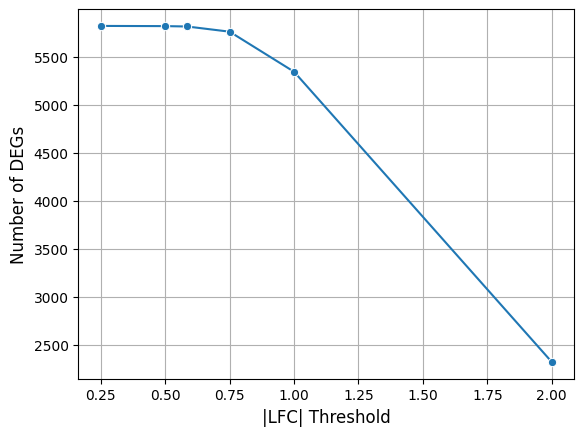

In [ ]:
ax = sns.lineplot(x=[0.25, 0.5, 0.585, 0.75, 1, 2], y=[5820, 5818, 5814, 5760, 5343, 2324], marker="o")
plt.xlabel("|LFC| Threshold", fontsize=12)
plt.ylabel("Number of DEGs", fontsize=12)
plt.grid()

### Filter genes to the 5820 DEGs with LFC > 0.25

Filter genes in TF-KO-by-gene dataset to the 5820 DEGs that pass LFC threshold

In [ ]:
adata_tfs_degs = adata_tfs[:, adata_tfs.var.index.isin(degs_filt)].copy()
adata_tfs_degs

AnnData object with n_obs × n_vars = 31808 × 5818
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
adata_tfs_degs.write("/home/ranwyl/data_tf_project/tf_kos_by_5820_degs.h5ad")

### Filter genes to the 5760 DEGs with |LFC| > 0.75

In [ ]:
degs_filt_075 = filter_degs_lfc(deg_df, lfc_threshold=0.75)
adata_tfs_degs_075 = adata_tfs[:, adata_tfs.var.index.isin(degs_filt_075)].copy()
adata_tfs_degs_075

AnnData object with n_obs × n_vars = 31808 × 5758
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
adata_tfs_degs_075.write("/home/ranwyl/data_tf_project/tf_kos_by_5760_degs.h5ad")

### Filter genes to the 5343 DEGs with |LFC| > 1

Filter genes in TF-KO-by-gene dataset to the 5343 DEGs that pass LFC threshold of 1

In [ ]:
degs_filt_1 = filter_degs_lfc(deg_df, lfc_threshold=1)
adata_tfs_degs_1 = adata_tfs[:, adata_tfs.var.index.isin(degs_filt_1)].copy()
adata_tfs_degs_1

AnnData object with n_obs × n_vars = 31808 × 5341
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
adata_tfs_degs_1.write("/home/ranwyl/data_tf_project/tf_kos_by_5343_degs.h5ad")

### Filter genes to the 2324 DEGs with |LFC| > 2

Filter genes in TF-KO-by-gene dataset to the 2324 DEGs that pass LFC threshold of 2

In [ ]:
degs_filt_2 = filter_degs_lfc(deg_df, lfc_threshold=2)
adata_tfs_degs_2 = adata_tfs[:, adata_tfs.var.index.isin(degs_filt_2)].copy()
adata_tfs_degs_2

AnnData object with n_obs × n_vars = 31808 × 2324
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
adata_tfs_degs_2.write("/home/ranwyl/data_tf_project/tf_kos_by_2324_degs.h5ad")

### Filter genes to 2000 HVGs

In [ ]:
adata_tfs_2000 = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_tfs_2000, n_top_genes=2000, subset=True, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [ ]:
adata_tfs_2000

AnnData object with n_obs × n_vars = 31808 × 2000
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
adata_tfs_2000.write("/home/ranwyl/data_tf_project/tf_kos_by_2000_hvgs.h5ad")

### Filter genes to the intersection of 5820 DEGs and 5000 HVGs (2017 genes total)

Filter genes in TF-KO-by-gene dataset to the intersection of 5820 DEGs + 5000 HVGs (2017 genes)

In [ ]:
adata_tfs_5000_hvg = adata_tfs.copy()
sc.pp.highly_variable_genes(adata_tfs_5000_hvg, n_top_genes=5000, subset=False, flavor='seurat_v3', layer='counts', batch_key='run', span=0.5)
unique_hvg_5000 = set(adata_tfs_5000_hvg[:, adata_tfs_5000_hvg.var['highly_variable']].var.index)
genes_intersec_5000 = list(degs_filt.intersection(unique_hvg_5000))
adata_tfs_intersec = adata_tfs[:, adata_tfs.var.index.isin(genes_intersec_5000)].copy()

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [ ]:
adata_tfs_intersec

AnnData object with n_obs × n_vars = 31808 × 2017
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'run', 'gene_target_ensembl_id', 'gene_target_expression (CPM)', 'NTC_target_gene_expression (CPM)', 'target_knockdown', 'target_knockdown_z_score', 'ed_category', 'anomaly_score'
    var: 'n_cells'
    obsm: 'X_pca'
    layers: 'counts', 'normalized_counts', 'pre_z_normalization'

In [ ]:
adata_tfs_intersec.write("/home/ranwyl/data_tf_project/tf_kos_by_2017_genes.h5ad")

## Pairwise Pearson correlation matrix of mean profiles

### Modifying and testing code for plotting pairwise Pearson correlation matrix of mean profiles

In [ ]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_5800_degs.h5ad")

Write modified function for computing mean normalized profiles and generating pairwise Pearson correlation matrix that runs on a subset of the data

In [ ]:
def compute_mean_profile(adata, group_indices):
    mean_vector = adata[group_indices, :].X.mean(axis=0)
    return mean_vector.A1 if hasattr(mean_vector, 'A1') else mean_vector

def test_create_corrmatrix(adata, n_gene_targets, n_jobs):
    # Subset gene targets for testing
    gene_target_list = sorted(adata.obs["gene_target"].unique().tolist())
    gene_targets = gene_target_list[:n_gene_targets]
    adata = adata[adata.obs["gene_target"].isin(gene_targets)].copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices
    print(f"Number of gene target groups: {len(gene_target_groups)}")

    # Initialize tqdm progress bar
    with tqdm_joblib(desc="Computing mean profiles", total=len(gene_target_groups)) as progress_bar:
        # Compute the mean expression profile for each group in parallel
        mean_profiles = Parallel(n_jobs=n_jobs)(delayed(compute_mean_profile)(adata, indices) 
                                                for indices in gene_target_groups.values())
    mean_profiles = np.array(mean_profiles)
    corr_matrix = np.corrcoef(mean_profiles)

    # Plot
    gene_target_labels = list(gene_target_groups.keys())
    distance_df = pd.DataFrame(corr_matrix, index=gene_target_labels, columns=gene_target_labels)
    fig = sns.clustermap(distance_df,cmap="RdBu",xticklabels=False, yticklabels=False,vmax=1,vmin=-1,center=0)
    fig.ax_heatmap.set_xlabel('')
    fig.ax_heatmap.set_ylabel('');
    return(distance_df, mean_profiles)

Measure RAM usage with different values of `gene_target_groups`

-  20 targets, 20 jobs: before 157Gb, after 163 Gb = 6 Gb used
-  50 targets, 50 jobs: before 163 Gb, after 171 Gb = 8 Gb used
-  100 targets, 25 jobs: before 96Gb, after 90Gb somehow
-  250 targets, 25 jobs: before 90Gb, after 92Gb
-  500 targets, 25 jobs: before 92Gb, after 89Gb
-  Very fast and should be no problem to run on full dataset

Number of gene target groups: 500


Computing mean profiles:   0%|          | 0/500 [00:00<?, ?it/s]

/home/ranwyl/newenv/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/home/ranwyl/newenv/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


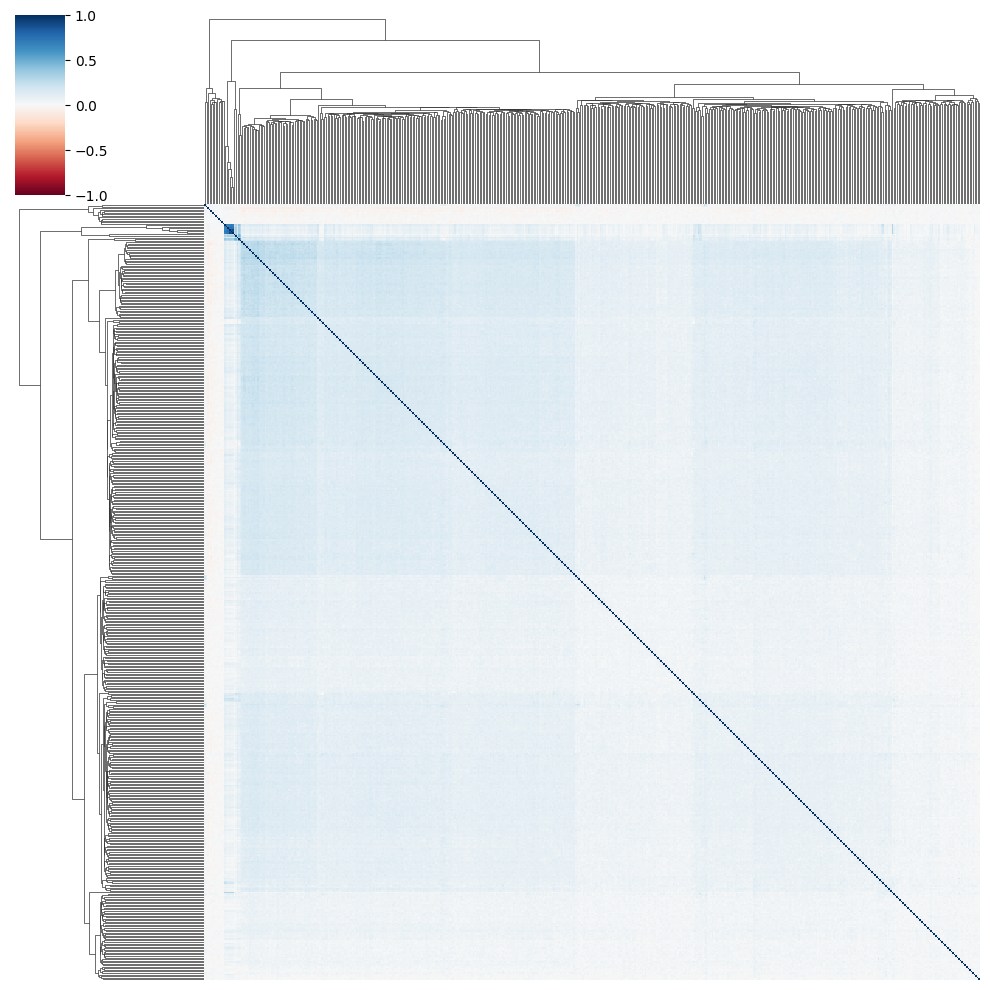

In [ ]:
ddf, mp = test_create_corrmatrix(adata, 500, 25)

### Pairwise Pearson correlation matrix of mean profiles - final function

In [ ]:
def create_corrmatrix_parallel(adata, n_jobs):
    gene_target_groups = adata.obs.groupby('gene_target').indices
    # Initialize tqdm progress bar
    with tqdm_joblib(desc="Computing mean profiles", total=len(gene_target_groups)) as progress_bar:
        # Compute the mean expression profile for each group in parallel
        adata_mean_profiles = Parallel(n_jobs=n_jobs)(delayed(qc2.compute_mean_profile)(adata, indices) 
                                                for indices in gene_target_groups.values())
    adata_mean_profiles = np.array(adata_mean_profiles)
    corr_matrix = np.corrcoef(adata_mean_profiles)

    # Plot
    gene_target_labels = list(gene_target_groups.keys())
    distance_dataframe = pd.DataFrame(corr_matrix, index=gene_target_labels, columns=gene_target_labels)
    fig = sns.clustermap(distance_dataframe,cmap="RdBu",xticklabels=False, yticklabels=False,vmax=1,vmin=-1,center=0)
    fig.ax_heatmap.set_xlabel('')
    fig.ax_heatmap.set_ylabel('');
    return(distance_dataframe, adata_mean_profiles)

### Pairwise Pearson correlation matrix of mean profiles for 5820-DEG dataset (|LFC| > 0.25)

In [ ]:
adata_5820 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_5820_degs.h5ad")

Computing mean profiles:   0%|          | 0/652 [00:00<?, ?it/s]

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


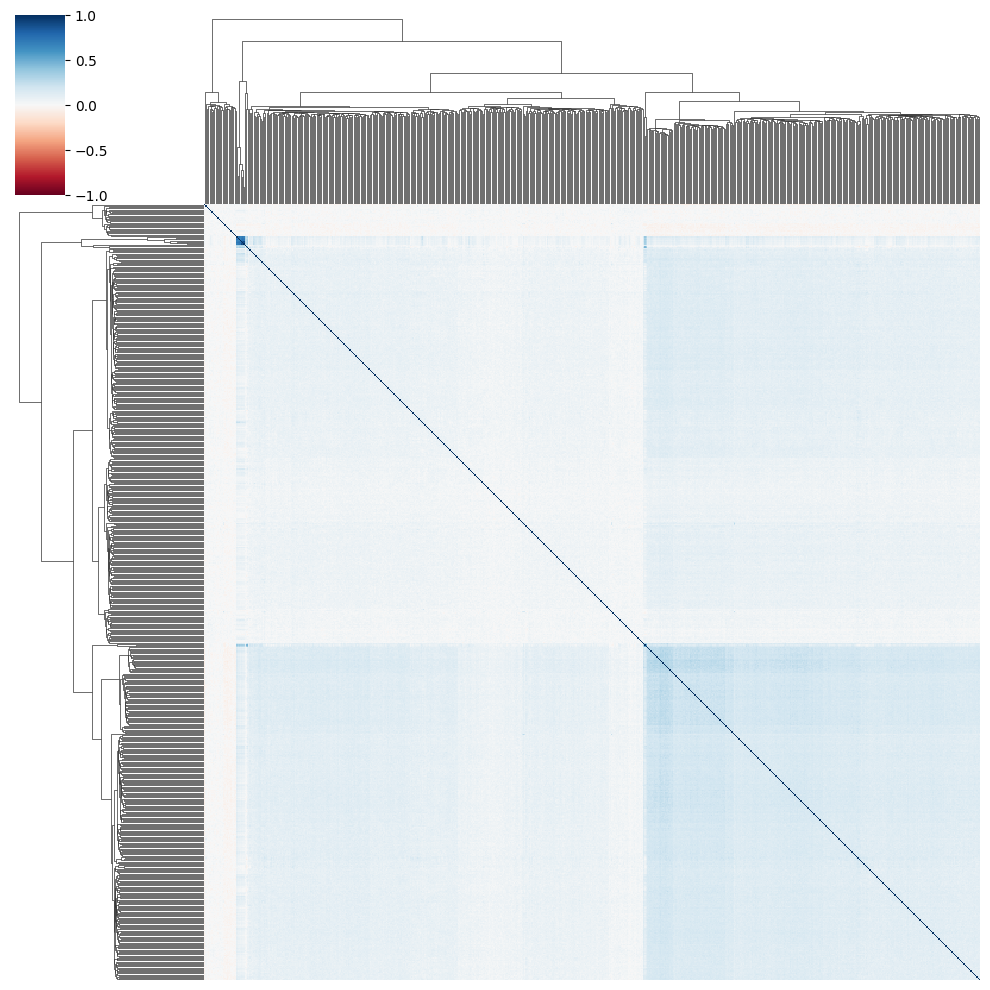

In [ ]:
distance_df_5820, mean_profiles_5820 = create_corrmatrix_parallel(adata_5820, 25)

### Pairwise Pearson correlation matrix of mean profiles for 5760-DEG dataset (|LFC| > 0.75)

In [ ]:
adata_5760 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_5760_degs.h5ad")

In [ ]:
#distance_df_5760, mean_profiles_5760 = create_corrmatrix_parallel(adata_5760, 25)

### Pairwise Pearson correlation matrix of mean profiles for 5343-DEG dataset (|LFC| > 1)

In [ ]:
adata_5343 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_5343_degs.h5ad")

In [ ]:
# distance_df_5343, mean_profiles_5343 = create_corrmatrix_parallel(adata_5343, 25)

### Pairwise Pearson correlation matrix of mean profiles for 2324-DEG dataset (|LFC| > 2)

In [ ]:
adata_2324 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2324_degs.h5ad")

In [ ]:
# distance_df_2324, mean_profiles_2324 = create_corrmatrix_parallel(adata_2324, 25)

### Pairwise Pearson correlation matrix of mean profiles for 2000-HVG dataset

In [ ]:
adata_2000 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2000_hvgs.h5ad")

Computing mean profiles:   0%|          | 0/652 [00:00<?, ?it/s]

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


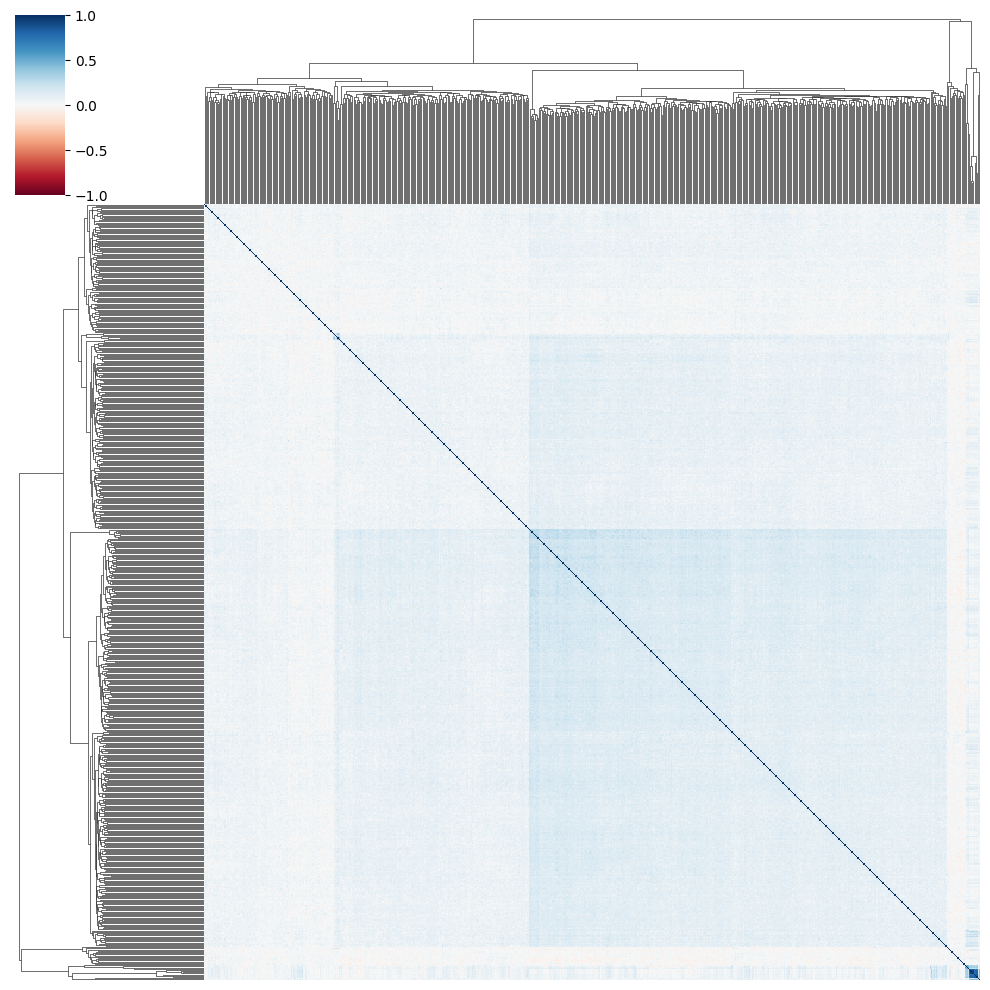

In [ ]:
distance_df_2000, mean_profiles_2000 = create_corrmatrix_parallel(adata_2000, 25)

### Pairwise Pearson correlation matrix of mean profiles for 2017-gene dataset

In [ ]:
adata_2017 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2017_genes.h5ad")

In [ ]:
# distance_df_2017, mean_profiles_2017 = create_corrmatrix_parallel(adata_2017, 25)

## MDE

### Modifying and testing code for mean normalized expression profile pairwise Pearson correlation matrix + MDE

In [ ]:
# def compute_mean_normalized_profile(adata, group_indices):
#     mean_vector = adata[group_indices, :].X.mean(axis=0)
#     normalized_mean_vector = (mean_vector - np.mean(mean_vector)) / np.std(mean_vector)
#     return normalized_mean_vector.A1 if hasattr(normalized_mean_vector, 'A1') else normalized_mean_vector

# def test_tf_compute_MDE(adata, n_gene_targets, n_jobs, leiden_neighbors=5, preserve='neighbors', spectral=False):
#     adata = adata.copy()

#     # Subset gene targets for testing
#     gene_target_list = sorted(adata.obs["gene_target"].unique().tolist())
#     gene_targets = gene_target_list[:n_gene_targets]
#     adata = adata[adata.obs["gene_target"].isin(gene_targets)].copy()
#     gene_target_groups = adata.obs.groupby('gene_target').indices
#     print(f"Number of gene target groups: {len(gene_target_groups)}")

#     # Initialize tqdm progress bar
#     with tqdm_joblib(desc="Computing mean profiles", total=len(gene_target_groups)) as progress_bar:
#         # Compute the mean expression profile for each group in parallel
#         mean_profiles = Parallel(n_jobs=n_jobs)(delayed(compute_mean_normalized_profile)(adata, indices) 
#                                                 for indices in gene_target_groups.values())
    
#     # Convert the list of mean profiles to a numpy array
#     mean_profiles_array = np.array(mean_profiles)

#     # Compute MDE
#     mde = None
#     embedding = None
#     if preserve == "neighbors":
#         if spectral:
#             spectral_embedding = SpectralEmbedding(
#                 n_components=30,  # Ensure this matches the pymde embedding dimension
#                 affinity='nearest_neighbors',
#                 n_neighbors=10,
#                 eigen_solver='arpack'
#             )
#             initial_embedding = spectral_embedding.fit_transform(mean_profiles_array)
#             mde = pymde.preserve_neighbors(initial_embedding, repulsive_fraction=15, n_neighbors = 15)
#             embedding = mde.embed(max_iter=2000,print_every=100,verbose=True)
#         else:
#             mde = pymde.preserve_neighbors(mean_profiles_array, repulsive_fraction=15, n_neighbors=5)
#             embedding = mde.embed(max_iter=4000,print_every=100,verbose=True)
#     else:
#         mde = pymde.preserve_distances(mean_profiles_array)
#         embedding = mde.embed(max_iter=1000,print_every=100,verbose=True)

    
#     # Run Leiden clustering on the embeddings
#     knn_graph = kneighbors_graph(embedding, n_neighbors=leiden_neighbors, include_self=False)
#     sources, targets = knn_graph.nonzero()
#     g = ig.Graph(directed=False)
#     g.add_vertices(embedding.shape[0])
#     g.add_edges(zip(sources, targets))
#     partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition)
    
#     # Get cluster labels and make pairwise correlation plot
#     clusters = np.array(partition.membership)
#     gene_targets = list(gene_target_groups.keys())
#     embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
#     embedding_df['gene_target'] = gene_targets
#     embedding_df['cluster'] = clusters
#     embedding_df['cluster'] = embedding_df['cluster'].astype(str)
#     cluster_groups = embedding_df.groupby('cluster')
#     centroids = cluster_groups[['x', 'y']].mean()
#     pairwise_distances = pd.DataFrame(
#         squareform(pdist(centroids, metric='euclidean')),
#         index=centroids.index,
#         columns=centroids.index
#     )
#     sns.clustermap(pairwise_distances, cmap='PuBuGn')
#     plt.title('Pairwise Distance Matrix of Cluster Centroids')
#     plt.show()


#     # Plot using Plotly with Pastel colormap for discrete clusters
#     fig = px.scatter(embedding_df, x='x', y='y', text='gene_target', color='cluster',
#                      hover_data={'x': True, 'y': True, 'gene_target': True},
#                      title='MDE Embedding of Mean Normalized Profiles',
#                      color_discrete_sequence=px.colors.qualitative.Bold)
#     fig.update_traces(marker=dict(size=7,opacity=0.7),textposition='middle center',textfont=dict(size=4))
    
    
#     fig.update_layout(
#         showlegend=True,
#         xaxis=dict(visible=False),
#         yaxis=dict(visible=False),
#         plot_bgcolor='white',
#         width=1200,  # Increase plot width
#         height=1000,  # Increase plot height
#         legend_title_text='Cluster',
#         coloraxis_showscale=False
#     )
   
#     fig.show()
    
#     return adata, embedding, clusters, mean_profiles_array

Tested different dataset sizes and monitor RAM + time elapsed (results not shown) - it works

Now we want to test why we are getting the error message: 

"/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,"

In [ ]:
def compute_mean_normalized_profile(adata, group_indices):
    mean_vector = adata[group_indices, :].X.mean(axis=0)
    normalized_mean_vector = (mean_vector - np.mean(mean_vector)) / np.std(mean_vector)
    return normalized_mean_vector.A1 if hasattr(normalized_mean_vector, 'A1') else normalized_mean_vector

def test_tf_compute_MDE(adata, n_jobs, label_points=False, leiden_neighbors=5, preserve='neighbors', spectral=False):
    adata = adata.copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices

    # Initialize tqdm progress bar
    with tqdm_joblib(desc="Computing mean profiles", total=len(gene_target_groups)) as progress_bar:
        # Compute the mean expression profile for each group in parallel
        mean_profiles = Parallel(n_jobs=n_jobs)(delayed(compute_mean_normalized_profile)(adata, indices) 
                                                for indices in gene_target_groups.values())
    
    # Convert the list of mean profiles to a numpy array
    mean_profiles_array = np.array(mean_profiles)

    # Compute MDE
    mde = None
    embedding = None
    if preserve == "neighbors":
        if spectral:
            spectral_embedding = SpectralEmbedding(
                n_components=30,  # Ensure this matches the pymde embedding dimension
                affinity='nearest_neighbors',
                n_neighbors=10,
                eigen_solver='arpack'
            )
            initial_embedding = spectral_embedding.fit_transform(mean_profiles_array)
            mde = pymde.preserve_neighbors(initial_embedding, repulsive_fraction=15, n_neighbors = 15)
            embedding = mde.embed(max_iter=2000,print_every=100,verbose=True)
        else:
            mde = pymde.preserve_neighbors(mean_profiles_array, repulsive_fraction=15, n_neighbors=5)
            embedding = mde.embed(max_iter=4000,print_every=100,verbose=True)
    else:
        mde = pymde.preserve_distances(mean_profiles_array)
        embedding = mde.embed(max_iter=1000,print_every=100,verbose=True)

    
    # Run Leiden clustering on the embeddings
    knn_graph = kneighbors_graph(embedding, n_neighbors=leiden_neighbors, include_self=False)
    sources, targets = knn_graph.nonzero()
    g = ig.Graph(directed=False)
    g.add_vertices(embedding.shape[0])
    g.add_edges(zip(sources, targets))
    partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition)
    
    # Get cluster labels and make pairwise correlation plot
    clusters = np.array(partition.membership)
    gene_targets = list(gene_target_groups.keys())
    embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
    embedding_df['gene_target'] = gene_targets
    embedding_df['cluster'] = clusters
    embedding_df['cluster'] = embedding_df['cluster'].astype(str)
    cluster_groups = embedding_df.groupby('cluster')
    centroids = cluster_groups[['x', 'y']].mean()
    pairwise_distances = pd.DataFrame(
        squareform(pdist(centroids, metric='euclidean')),
        index=centroids.index,
        columns=centroids.index
    )
    sns.clustermap(pairwise_distances, cmap='PuBuGn')
    plt.title('Pairwise Distance Matrix of Cluster Centroids')
    plt.show()


    # # Plot using Plotly with Pastel colormap for discrete clusters
    # fig = px.scatter(embedding_df, x='x', y='y', text='gene_target', color='cluster',
    #                  hover_data={'x': True, 'y': True, 'gene_target': True},
    #                  title='MDE Embedding of Mean Normalized Profiles',
    #                  color_discrete_sequence=px.colors.qualitative.Bold)
    # fig.update_traces(marker=dict(size=7,opacity=0.7),textposition='middle center',textfont=dict(size=4))
    
    
    # fig.update_layout(
    #     showlegend=True,
    #     xaxis=dict(visible=False),
    #     yaxis=dict(visible=False),
    #     plot_bgcolor='white',
    #     width=1200,  # Increase plot width
    #     height=1000,  # Increase plot height
    #     legend_title_text='Cluster',
    #     coloraxis_showscale=False
    # )
    # if not label_points:
    #     fig.update_traces(text=None)
   
    # fig.show()
    
    return adata, embedding, clusters, mean_profiles_array

def test_tf_compute_MDE_2(adata, n_jobs, label_points=False, leiden_neighbors=5, preserve='neighbors', spectral=False):
    adata = adata.copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices

    # Initialize tqdm progress bar
    with tqdm_joblib(desc="Computing mean profiles", total=len(gene_target_groups)) as progress_bar:
        # Compute the mean expression profile for each group in parallel
        mean_profiles = Parallel(n_jobs=n_jobs)(delayed(compute_mean_normalized_profile)(adata, indices) 
                                                for indices in gene_target_groups.values())
    
    # Convert the list of mean profiles to a numpy array
    mean_profiles_array = np.array(mean_profiles)

    # Compute MDE
    mde = None
    embedding = None
    if preserve == "neighbors":
        if spectral:
            spectral_embedding = SpectralEmbedding(
                n_components=30,  # Ensure this matches the pymde embedding dimension
                affinity='nearest_neighbors',
                n_neighbors=10,
                eigen_solver='arpack'
            )
            initial_embedding = spectral_embedding.fit_transform(mean_profiles_array)
            mde = pymde.preserve_neighbors(initial_embedding, repulsive_fraction=15, n_neighbors = 15)
            embedding = mde.embed(max_iter=2000,print_every=100,verbose=True)
        else:
            mde = pymde.preserve_neighbors(mean_profiles_array, repulsive_fraction=15, n_neighbors=5)
            embedding = mde.embed(max_iter=4000,print_every=100,verbose=True)
    else:
        mde = pymde.preserve_distances(mean_profiles_array)
        embedding = mde.embed(max_iter=1000,print_every=100,verbose=True)

    
    # Run Leiden clustering on the embeddings
    knn_graph = kneighbors_graph(embedding, n_neighbors=leiden_neighbors, include_self=False)
    sources, targets = knn_graph.nonzero()
    g = ig.Graph(directed=False)
    g.add_vertices(embedding.shape[0])
    g.add_edges(zip(sources, targets))
    partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition)
    
    # Get cluster labels and make pairwise correlation plot
    clusters = np.array(partition.membership)
    gene_targets = list(gene_target_groups.keys())
    embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
    embedding_df['gene_target'] = gene_targets
    embedding_df['cluster'] = clusters
    embedding_df['cluster'] = embedding_df['cluster'].astype(str)
    return embedding_df
    
    # pairwise_distances = pd.DataFrame(
    #     squareform(pdist(centroids, metric='euclidean')),
    #     index=centroids.index,
    #     columns=centroids.index
    # )
    # sns.clustermap(pairwise_distances, cmap='PuBuGn')
    # plt.title('Pairwise Distance Matrix of Cluster Centroids')
    # plt.show()

In [ ]:
adata_2012 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2012_genes.h5ad")

Computing mean profiles:   0%|          | 0/652 [00:00<?, ?it/s]

Apr 17 02:04:56 PM: Fitting a centered embedding into R^2, for a graph with 652 items and 128898 edges.
Apr 17 02:04:56 PM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Apr 17 02:04:56 PM: iteration 0000 | distortion 0.974530 | residual norm 0.111911 | step length 1.73742 | percent change 0.538439
Apr 17 02:04:57 PM: iteration 0100 | distortion 0.139406 | residual norm 0.000115798 | step length 1 | percent change 0.30733
Apr 17 02:04:58 PM: iteration 0200 | distortion 0.137794 | residual norm 4.5249e-05 | step length 1 | percent change 0.0578183
Apr 17 02:05:00 PM: iteration 0300 | distortion 0.137382 | residual norm 6.20392e-05 | step length 1 | percent change 0.293795
Apr 17 02:05:01 PM: Converged in 385 iterations, with residual norm 8.46434e-06
Apr 17 02:05:01 PM: Finished fitting in 5.323 seconds and 385 iterations.
Apr 17 02:05:01 PM: average distortion 0.137 | residual norm 8.5e-06


/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


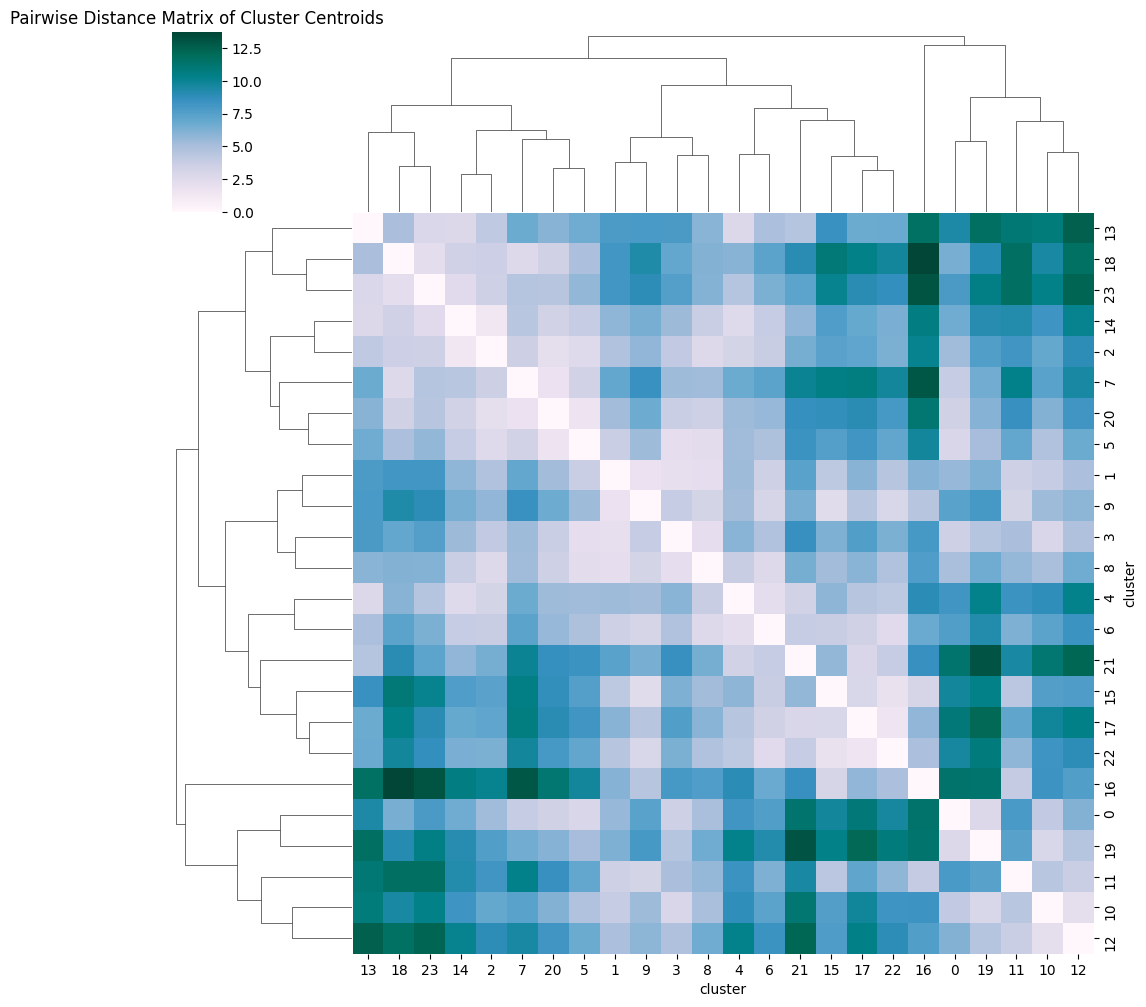

In [ ]:
test_adata, test_embedding, test_clusters, test_mp = test_tf_compute_MDE(adata_2012, 5, spectral=True, leiden_neighbors=8)

In [ ]:
test_embedding_df = test_tf_compute_MDE_2(adata_2012, 5, spectral=True, leiden_neighbors=8)

Computing mean profiles:   0%|          | 0/652 [00:00<?, ?it/s]

Apr 17 02:13:34 PM: Fitting a centered embedding into R^2, for a graph with 652 items and 128922 edges.
Apr 17 02:13:34 PM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Apr 17 02:13:34 PM: iteration 0000 | distortion 0.973552 | residual norm 0.114345 | step length 0.311499 | percent change 0.0986355
Apr 17 02:13:37 PM: iteration 0100 | distortion 0.141704 | residual norm 0.000205405 | step length 1 | percent change 0.499116
Apr 17 02:13:40 PM: iteration 0200 | distortion 0.140230 | residual norm 0.000120667 | step length 0.631188 | percent change 0.733236
Apr 17 02:13:43 PM: iteration 0300 | distortion 0.139719 | residual norm 3.67199e-05 | step length 1 | percent change 0.130888
Apr 17 02:13:45 PM: iteration 0400 | distortion 0.139194 | residual norm 7.99929e-05 | step length 1 | percent change 0.424733
Apr 17 02:13:47 PM: iteration 0500 | distortion 0.138897 | residual norm 1.91764e-05 | step length 1 | percent change 0.044975
Apr 17 02:13:49 PM: iteration 06

In [ ]:
cluster_groups = test_embedding_df.groupby('cluster')
centroids = cluster_groups[['x', 'y']].mean()
centroids

,x,y
cluster,,
0,-0.046596,-0.406438
1,-1.316051,1.885311
10,1.190665,-1.900266
11,0.748815,1.298265
12,-1.312611,-5.399751
13,-4.194056,3.612322
14,6.250611,-1.030417
15,-7.694043,-0.612885
16,2.545876,1.978286


In [ ]:
pdist_mat = pdist(centroids, metric='euclidean')
pdist_mat.shape

(231,)

In [ ]:
pdist_mat

array([ 2.6198535 ,  1.93967396,  1.88114091,  5.15130746,  5.77510693,
        6.3280459 ,  7.65023314,  3.52247346,  7.27817722,  5.46037413,
        6.14163921,  2.96979007,  6.32561903,  7.54414014,  2.96502353,
        5.2201237 ,  4.53589409,  4.48038145,  4.00657474,  5.15274694,
        5.72957208,  4.54028841,  2.14669419,  7.28506336,  3.35640856,
        8.10899801,  6.8498005 ,  3.8630458 ,  5.38530643,  6.70946324,
        8.76019619,  4.12225246,  6.37593635,  5.02579284,  4.93712263,
        4.52461074,  3.21261507,  6.95650762,  6.54333446,  6.24502085,
        3.22394729,  3.22890523,  4.30264898,  7.70609141,  5.1341689 ,
        8.97749317,  4.10849859,  8.72348079,  5.59073271,  4.23297008,
        3.70818788,  7.26356072,  9.35354785,  2.10935912,  6.13952743,
        6.24879988,  2.63077424,  2.50027825,  4.7575672 ,  7.55060621,
        7.00805935,  5.45773171,  5.97432161,  8.65646275,  1.92142025,
        5.51913268,  7.2644011 ,  7.35726384,  4.68166575,  7.73

In [ ]:
squareform_mat = squareform(pdist_mat)
squareform_mat.shape

(22, 22)

In [ ]:
squareform_mat

array([[ 0.        ,  2.6198535 ,  1.93967396,  1.88114091,  5.15130746,
         5.77510693,  6.3280459 ,  7.65023314,  3.52247346,  7.27817722,
         5.46037413,  6.14163921,  2.96979007,  6.32561903,  7.54414014,
         2.96502353,  5.2201237 ,  4.53589409,  4.48038145,  4.00657474,
         5.15274694,  5.72957208],
       [ 2.6198535 ,  0.        ,  4.54028841,  2.14669419,  7.28506336,
         3.35640856,  8.10899801,  6.8498005 ,  3.8630458 ,  5.38530643,
         6.70946324,  8.76019619,  4.12225246,  6.37593635,  5.02579284,
         4.93712263,  4.52461074,  3.21261507,  6.95650762,  6.54333446,
         6.24502085,  3.22394729],
       [ 1.93967396,  4.54028841,  0.        ,  3.22890523,  4.30264898,
         7.70609141,  5.1341689 ,  8.97749317,  4.10849859,  8.72348079,
         5.59073271,  4.23297008,  3.70818788,  7.26356072,  9.35354785,
         2.10935912,  6.13952743,  6.24879988,  2.63077424,  2.50027825,
         4.7575672 ,  7.55060621],
       [ 1.88114091

### MDE function

In [32]:
def compute_mean_normalized_profile(adata, group_indices):
    mean_vector = adata[group_indices, :].X.mean(axis=0)
    normalized_mean_vector = (mean_vector - np.mean(mean_vector)) / np.std(mean_vector)
    return normalized_mean_vector.A1 if hasattr(normalized_mean_vector, 'A1') else normalized_mean_vector

def tf_compute_MDE(adata, n_jobs, label_points=False, leiden_neighbors=5, preserve='neighbors', spectral=False):
    adata = adata.copy()
    gene_target_groups = adata.obs.groupby('gene_target').indices

    # Initialize tqdm progress bar
    with tqdm_joblib(desc="Computing mean profiles", total=len(gene_target_groups)) as progress_bar:
        # Compute the mean expression profile for each group in parallel
        mean_profiles = Parallel(n_jobs=n_jobs)(delayed(compute_mean_normalized_profile)(adata, indices) 
                                                for indices in gene_target_groups.values())
    
    # Convert the list of mean profiles to a numpy array
    mean_profiles_array = np.array(mean_profiles)

    # Compute MDE
    mde = None
    embedding = None
    if preserve == "neighbors":
        if spectral:
            spectral_embedding = SpectralEmbedding(
                n_components=30,  # Ensure this matches the pymde embedding dimension
                affinity='nearest_neighbors',
                n_neighbors=10,
                eigen_solver='arpack'
            )
            initial_embedding = spectral_embedding.fit_transform(mean_profiles_array)
            mde = pymde.preserve_neighbors(initial_embedding, repulsive_fraction=15, n_neighbors = 15)
            embedding = mde.embed(max_iter=2000,print_every=100,verbose=True)
        else:
            mde = pymde.preserve_neighbors(mean_profiles_array, repulsive_fraction=15, n_neighbors=5)
            embedding = mde.embed(max_iter=4000,print_every=100,verbose=True)
    else:
        mde = pymde.preserve_distances(mean_profiles_array)
        embedding = mde.embed(max_iter=1000,print_every=100,verbose=True)

    
    # Run Leiden clustering on the embeddings
    knn_graph = kneighbors_graph(embedding, n_neighbors=leiden_neighbors, include_self=False)
    sources, targets = knn_graph.nonzero()
    g = ig.Graph(directed=False)
    g.add_vertices(embedding.shape[0])
    g.add_edges(zip(sources, targets))
    partition = leidenalg.find_partition(g, leidenalg.RBConfigurationVertexPartition)
    
    # Get cluster labels and make pairwise correlation plot
    clusters = np.array(partition.membership)
    gene_targets = list(gene_target_groups.keys())
    embedding_df = pd.DataFrame(embedding, columns=['x', 'y'])
    embedding_df['gene_target'] = gene_targets
    embedding_df['cluster'] = clusters
    embedding_df['cluster'] = embedding_df['cluster'].astype(str)
    cluster_groups = embedding_df.groupby('cluster')
    centroids = cluster_groups[['x', 'y']].mean()
    pairwise_distances = pd.DataFrame(
        squareform(pdist(centroids, metric='euclidean')),
        index=centroids.index,
        columns=centroids.index
    )
    sns.clustermap(pairwise_distances, cmap='PuBuGn')
    plt.title('Pairwise Distance Matrix of Cluster Centroids')
    plt.show()


    # Plot using Plotly with Pastel colormap for discrete clusters
    fig = px.scatter(embedding_df, x='x', y='y', text='gene_target', color='cluster',
                     hover_data={'x': True, 'y': True, 'gene_target': True},
                     title='MDE Embedding of Mean Normalized Profiles',
                     color_discrete_sequence=px.colors.qualitative.Bold)
    fig.update_traces(marker=dict(size=7,opacity=0.7),textposition='middle center',textfont=dict(size=4))
    
    
    fig.update_layout(
        showlegend=True,
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        plot_bgcolor='white',
        width=1200,  # Increase plot width
        height=1000,  # Increase plot height
        legend_title_text='Cluster',
        coloraxis_showscale=False
    )
    if not label_points:
        fig.update_traces(text=None)
   
    fig.show()
    
    return adata, embedding, clusters, mean_profiles_array, embedding_df

def gene_targets_per_cluster(embedding_df):
    """
    Return DataFrame where each column contains the perturbations in a cluster.
    """
    cluster_nums = max([int(n) for n in set(embedding_df["cluster"].tolist())])
    cluster_dict = dict()
    for i in range(cluster_nums+1):
        cluster = embedding_df[embedding_df["cluster"] == str(i)]["gene_target"].tolist()
        cluster_dict[i] = cluster
    # Pad all columns to be the same length
    max_n_perts = max(len(cluster_dict[i]) for i in range(len(cluster_dict)))
    cluster_dict = {cluster:(perts + [""]*(max_n_perts-len(perts))) for cluster, perts in cluster_dict.items()}
    perts_in_cluster_df = pd.DataFrame(cluster_dict)
    return perts_in_cluster_df

### MDE on 5820 DEG dataset

In [15]:
adata_5820 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_5820_degs.h5ad")

Computing mean profiles:   0%|          | 0/652 [00:00<?, ?it/s]

Apr 25 01:23:29 AM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Apr 25 01:23:29 AM: The following items have duplicates [149 611]
Apr 25 01:23:29 AM: Fitting a centered embedding into R^2, for a graph with 652 items and 133138 edges.
Apr 25 01:23:29 AM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Apr 25 01:23:29 AM: iteration 0000 | distortion 0.806272 | residual norm 0.083606 | step length 0.448289 | percent change 0.10379
Apr 25 01:23:32 AM: iteration 0100 | distortion 0.137608 | residual norm 0.00012345 | step length 1 | percent change 1.06351
Apr 25 01:23:35 AM: iteration 0200 | distortion 0.136278 | residual norm 7.56316e-05 | step length 1 | percent change 0.478858
Apr 25 01:23:39 AM: iteration 0300 | distortion 0.135664 | residual norm 6.36404e-05 | step length 1 | percent change 0.22788
Apr 25 01:23:42 AM: iteration 0400 | distortion 0.135180 | residual norm 0.000120393 | step length 

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



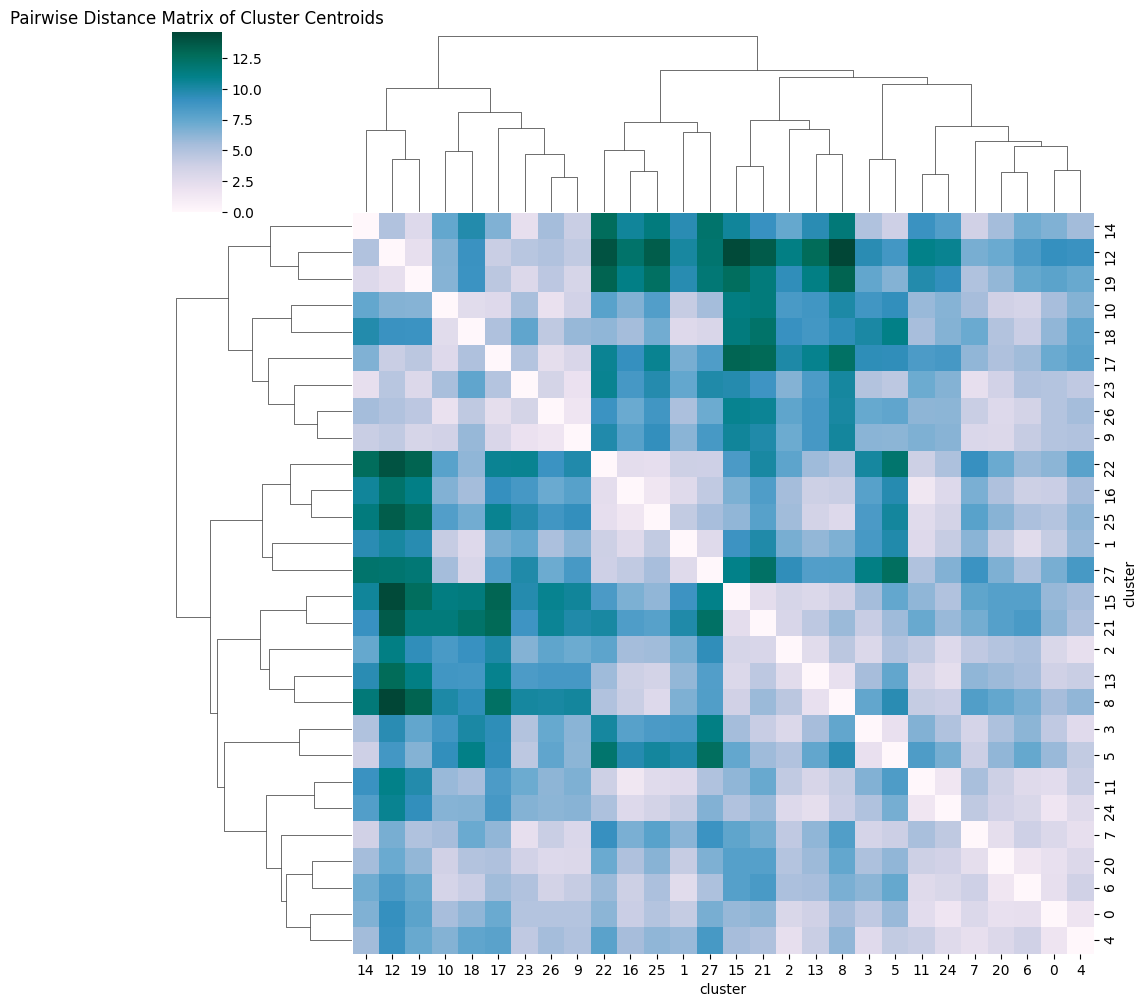

In [20]:
mde_5820 = tf_compute_MDE(adata_5820, n_jobs=5, label_points=False, spectral=True, leiden_neighbors=8)

In [21]:
_, _, _, _, embedding_df_5820 = mde_5820
embedding_df_5820.head()

,x,y,gene_target,cluster
0,0.736766,-2.898307,ADNP2,3
1,-1.230941,1.361896,AEBP1,6
2,5.932528,3.338254,AHR,8
3,2.848809,-1.552293,AIRE,2
4,-4.627402,-1.164467,AKAP8,9


In [23]:
perts_in_cluster_5820 = gene_targets_per_cluster(embedding_df_5820)
perts_in_cluster_5820.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,ASH1L,ARID2,AIRE,ADNP2,ERF,DACH2,AEBP1,CAMTA2,AHR,AKAP8,...,ATOH1,ARID3B,CREM,BACH2,GMEB2,ASCL3,BCL6B,BAZ2A,BARHL1,ATMIN
1,DLX6,ASCL2,ATOH7,AKAP8L,ERG,ETS1,CEBPA,DBX2,ESRRG,ASCL5,...,CENPB,CBX2,ESR2,CREBL2,MTERF3,HOXA7,GLIS3,BHLHE40,NFIB,CHAMP1
2,DMRT3,BHLHA9,BHLHA15,ATF6B,FOSB,IRX1,CRX,DMRTA2,ETV1,EBF3,...,CENPS,CREB3L4,GATA3,FOXO1,MTERF4,JAZF1,MEOX1,CDX1,SMAD9,DLX4
3,EPAS1,CCDC17,BHLHE41,CEBPB,FOXN2,L3MBTL4,HES3,DMRTB1,FOXN4,GATA2,...,DR1,EBF2,NKX6-2,HHEX,NFE2L3,NCOA3,MYCL,EMX1,TWIST1,DNMT1
4,FOXK2,CEBPE,DMBX1,DEAF1,GATA1,LTF,HLF,DUXA,GTF2I,GLI1,...,DRAP1,KLF1,NR1I3,RARB,POGK,PBX3,OSR2,FAM200B,ZFP90,PITX3


In [33]:
n_perts_per_cluster_5280 = perts_in_cluster_5820.nunique().tolist()
print(n_perts_per_cluster_5280)

[46, 46, 44, 43, 39, 35, 32, 32, 32, 30, 29, 25, 24, 23, 22, 17, 17, 16, 16, 15, 15, 14, 12, 12, 11, 11, 11, 10]


In [45]:
with pd.ExcelWriter("/home/ranwyl/results_tf_project/tf_kos_in_cluster_5280.xlsx") as writer:
    perts_in_cluster_5820.to_excel(writer, sheet_name="TF KOs per cluster", index=False)

In [ ]:
pd.to_excel

In [31]:
genes_5820 = adata_5820.var.index.tolist()
genes_5820 = set(genes_5820)
genes_2000 = adata_2000.var.index.tolist()
genes_2000 = set(genes_2000)
print(len(genes_2000 - genes_5820))
print(len(genes_5820 - genes_2000))
print(len(genes_5820))

1199
5017
5818


### MDE on 2324 gene dataset

In [ ]:
adata_2324 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2324_degs.h5ad")

Computing mean profiles:   0%|          | 0/652 [00:00<?, ?it/s]

Apr 21 02:05:18 AM: Fitting a centered embedding into R^2, for a graph with 652 items and 127064 edges.
Apr 21 02:05:18 AM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Apr 21 02:05:18 AM: iteration 0000 | distortion 0.862958 | residual norm 0.0824132 | step length 0.426221 | percent change 0.0972731
Apr 21 02:05:21 AM: iteration 0100 | distortion 0.139619 | residual norm 0.000164302 | step length 1 | percent change 0.344872
Apr 21 02:05:24 AM: iteration 0200 | distortion 0.137891 | residual norm 0.000130736 | step length 1 | percent change 0.174981
Apr 21 02:05:27 AM: iteration 0300 | distortion 0.136872 | residual norm 6.71833e-05 | step length 1 | percent change 0.297267
Apr 21 02:05:30 AM: iteration 0400 | distortion 0.136558 | residual norm 3.60009e-05 | step length 1 | percent change 0.0730612
Apr 21 02:05:32 AM: iteration 0500 | distortion 0.136422 | residual norm 4.68058e-05 | step length 1 | percent change 0.0392103
Apr 21 02:05:35 AM: iteration 0600 |

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



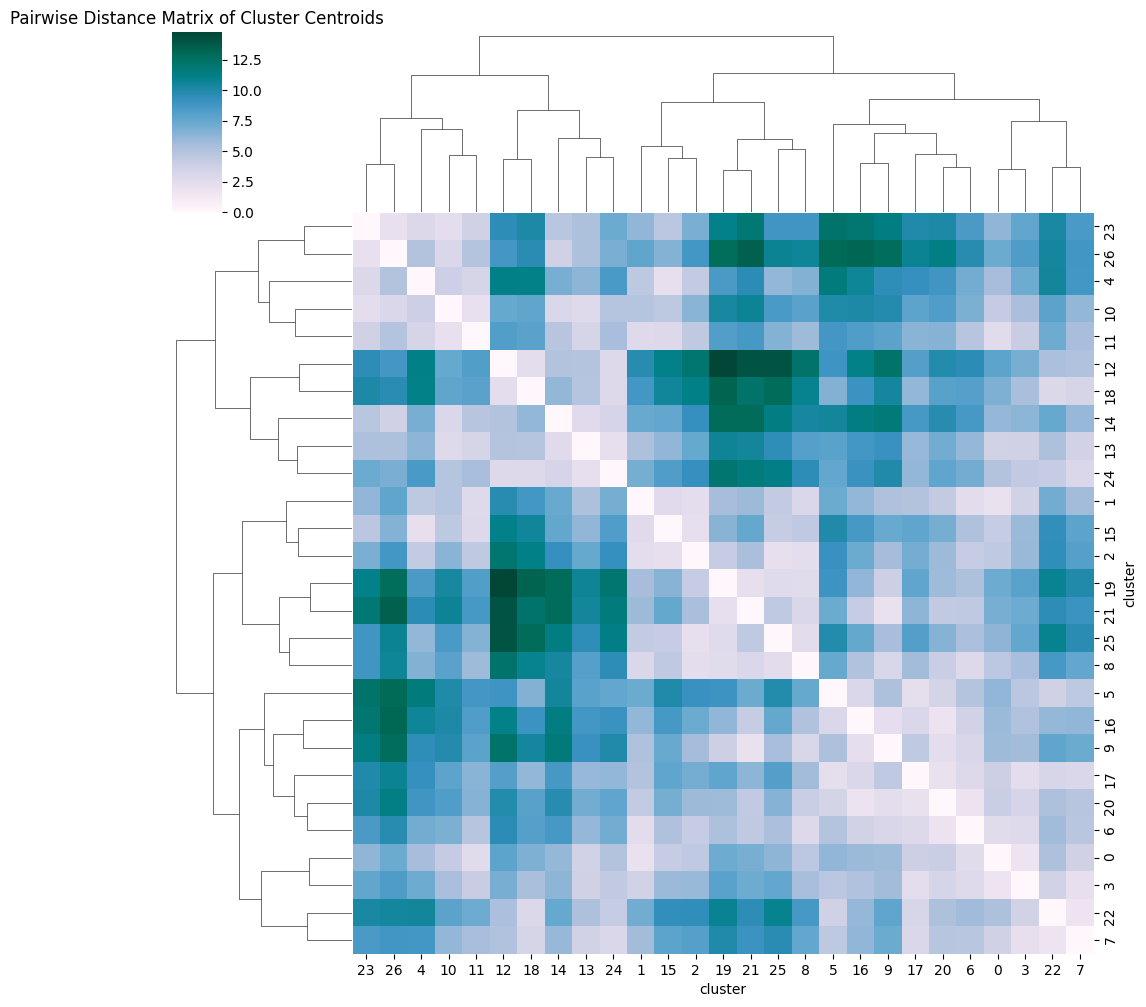

In [ ]:
mde_2324 = tf_compute_MDE(adata_2324, n_jobs=5, label_points=False, spectral=True,leiden_neighbors=8)

### MDE on 2000 HVG dataset

In [41]:
adata_2000 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2000_hvgs.h5ad")

Computing mean profiles:   0%|          | 0/652 [00:00<?, ?it/s]

Apr 25 02:14:17 AM: Fitting a centered embedding into R^2, for a graph with 652 items and 129695 edges.
Apr 25 02:14:17 AM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Apr 25 02:14:17 AM: iteration 0000 | distortion 0.800326 | residual norm 0.072427 | step length 2.66917 | percent change 0.535351
Apr 25 02:14:18 AM: iteration 0100 | distortion 0.139319 | residual norm 0.000194949 | step length 1 | percent change 0.378073
Apr 25 02:14:19 AM: iteration 0200 | distortion 0.138145 | residual norm 4.73336e-05 | step length 1 | percent change 0.171173
Apr 25 02:14:20 AM: iteration 0300 | distortion 0.137775 | residual norm 0.000154933 | step length 1 | percent change 0.376592
Apr 25 02:14:22 AM: iteration 0400 | distortion 0.137529 | residual norm 2.08446e-05 | step length 1 | percent change 0.0655341
Apr 25 02:14:22 AM: Converged in 432 iterations, with residual norm 9.22482e-06
Apr 25 02:14:22 AM: Finished fitting in 5.514 seconds and 432 iterations.
Apr 25 02:14:

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



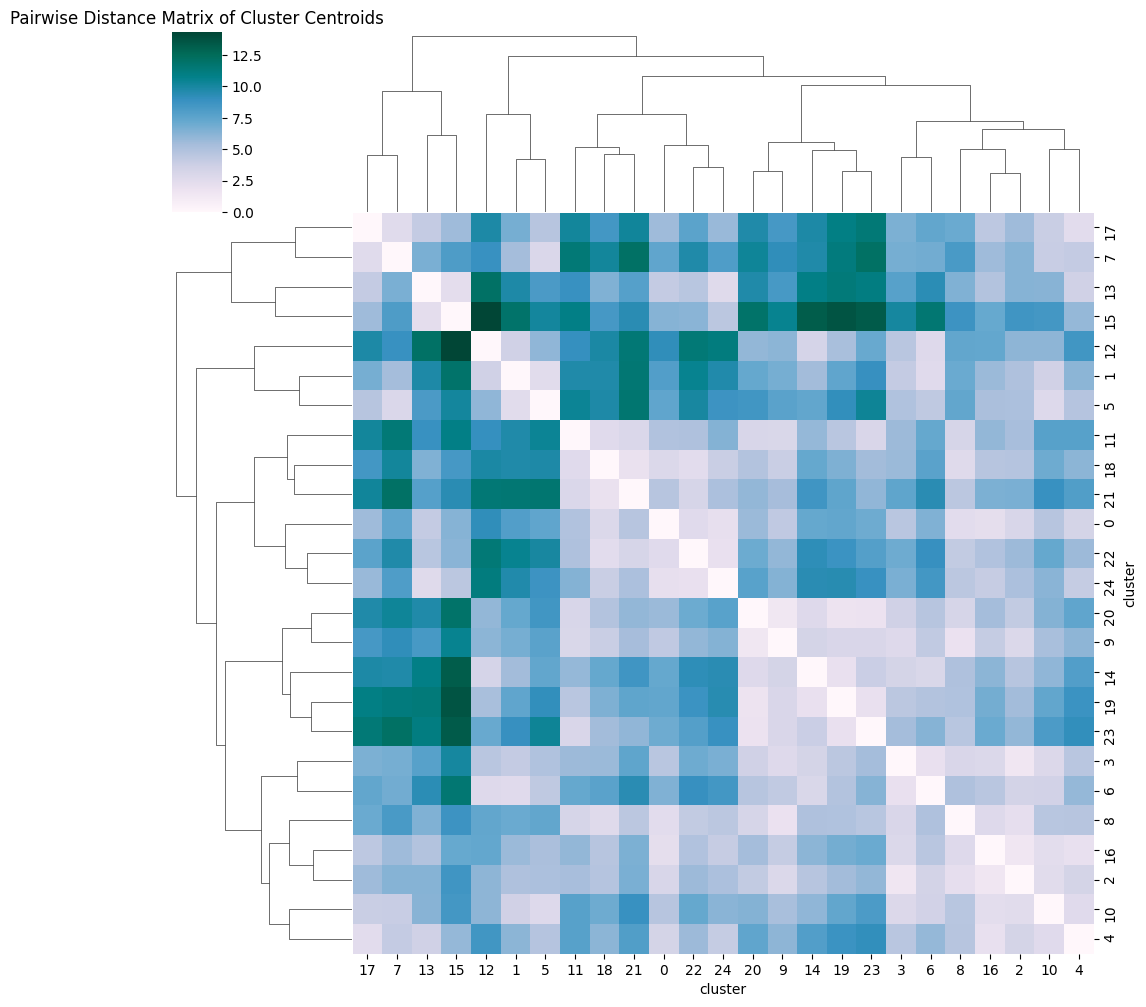

In [42]:
mde_2000 = tf_compute_MDE(adata_2000, n_jobs=5, label_points=False, spectral=True,leiden_neighbors=8)

In [43]:
_, _, _, _, embedding_df_2000 = mde_2000

In [44]:
perts_in_cluster_2000 = gene_targets_per_cluster(embedding_df_2000)
perts_in_cluster_2000.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,ASCL5,AIRE,ARX,ADNP2,AEBP1,BAZ2A,BHLHA9,AKAP8,ATOH7,AHR,...,ASCL1,CCDC17,ARHGAP35,BHLHA15,ANKZF1,DMRTC2,DACH2,EBF2,ELF3,ARID2
1,CEBPE,ARID3B,BHLHE41,CREB3L3,BARX1,BHLHE22,CREB5,AKAP8L,BCL6B,CREB3L4,...,FLYWCH1,ESRRA,ASCL3,DMBX1,CC2D1A,LHX5,GRHL2,FOXD3,FOSB,ATOH1
2,DLX2,ARNT2,CREBL2,DLX6,CAMTA2,CBX2,ELK1,ATF6B,BHLHE40,CSRNP2,...,HMX2,GRHL3,BACH2,DOT1L,CEBPA,NR1H4,MTERF1,FOXH1,HBP1,DLX4
3,EMX1,CDX1,DMRTB1,DUXA,CREM,CEBPD,ESRRB,CEBPB,DBX2,FOXI2,...,HOXD13,MKX,CTCFL,EHF,GATA5,PA2G4,MTERF3,GTF2I,NKX6-2,DR1
4,FOXJ2,FOXD4L5,EPAS1,ERF,EBF3,ESX1,ESRRG,CENPB,DEAF1,GATA1,...,MBD1,MLXIP,FAM200B,FOXA1,HNF1B,PCGF2,MTERF4,JUNB,RUNX3,DRAP1


In [45]:
n_perts_per_cluster_2000 = perts_in_cluster_2000.nunique().tolist()
print(n_perts_per_cluster_2000)

[41, 41, 39, 37, 36, 36, 33, 33, 32, 32, 30, 29, 28, 27, 25, 24, 22, 20, 19, 19, 15, 15, 14, 14, 14]


### MDE on 2017 gene dataset

In [ ]:
adata_2017 = ad.read_h5ad("/home/ranwyl/data_tf_project/tf_kos_by_2017_genes.h5ad")

Computing mean profiles:   0%|          | 0/652 [00:00<?, ?it/s]

Apr 21 02:11:01 AM: Fitting a centered embedding into R^2, for a graph with 652 items and 128670 edges.
Apr 21 02:11:01 AM: `embed` method parameters: eps=1.0e-05, max_iter=2000, memory_size=10
Apr 21 02:11:01 AM: iteration 0000 | distortion 0.928323 | residual norm 0.0946834 | step length 11.2357 | percent change 2.94601
Apr 21 02:11:02 AM: iteration 0100 | distortion 0.139795 | residual norm 0.000166792 | step length 1 | percent change 1.7624
Apr 21 02:11:04 AM: iteration 0200 | distortion 0.138356 | residual norm 9.37202e-05 | step length 1 | percent change 0.522527
Apr 21 02:11:05 AM: iteration 0300 | distortion 0.137983 | residual norm 2.30281e-05 | step length 1 | percent change 0.0933294
Apr 21 02:11:07 AM: iteration 0400 | distortion 0.137826 | residual norm 2.59021e-05 | step length 1 | percent change 0.118517
Apr 21 02:11:08 AM: iteration 0500 | distortion 0.137652 | residual norm 2.24556e-05 | step length 1 | percent change 0.0840364
Apr 21 02:11:10 AM: iteration 0600 | dist

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

/home/ranwyl/pymde_env/lib64/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



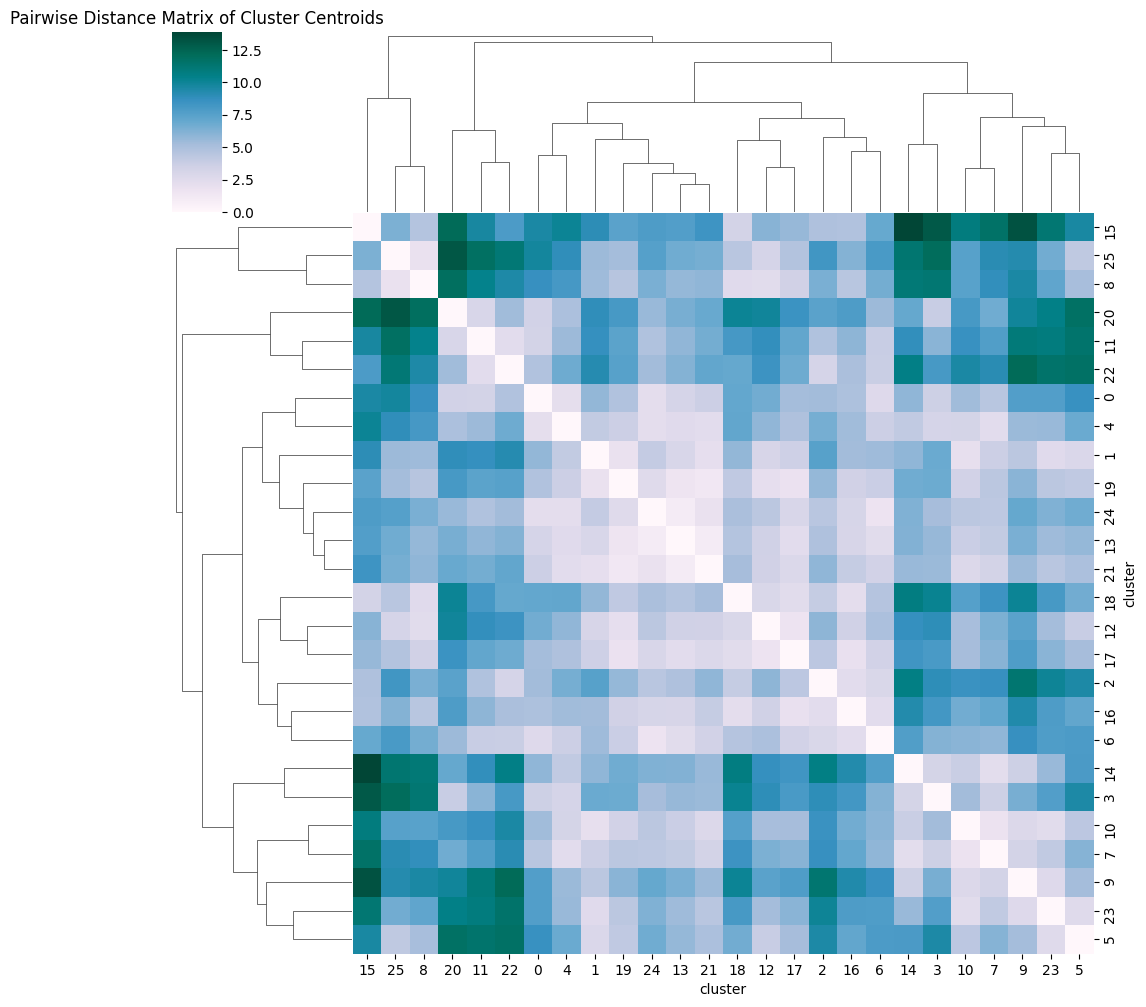

In [ ]:
mde_2017 = tf_compute_MDE(adata_2017, n_jobs=5, label_points=False, spectral=True,leiden_neighbors=8)